# Benchmark: PXD014777 HeLa 10 replicate dataset

This notebook contains code to benchmark the PIPP model on [PXD014777 HeLa 10 replicate dataset](https://proteomecentral.proteomexchange.org/cgi/GetDataset?ID=PXD014777). Here, we'll use two txt files from the dataset:

- allPeptides.txt: All the peptides with MS-1 data
- evidence.txt: A subset of the peptides in allPeptides.txt, which contains both MS-1 and MS-2 data

We'll use PIPP to compute the embeddings of each MS-1 datapoint. Followed by peptide identity propagation using the MS1/MS2 data as the support data.

In [ ]:
# @TODO: map evidence.txt <-> allPeptides.txt
# @TODO: connected scatter plot as a function of threshold (double plot: identifications + correctly predicted identifications)
# @TODO: heatmap (expression matrix)
# @TODO: move PIP code to library
# @TODO: compute CV

Let's start with the imports.

In [1]:
%%capture

%matplotlib inline

%load_ext autoreload
%autoreload 2

from collections import defaultdict
import re

import pipp
import pandas as pd
import umap
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import numba

from pynndescent import NNDescent

np.random.seed(0)

Let's define the paths to the data and the pretrained model.

In [2]:
PEPTIDES_PATH = "../../data/txt/allPeptides.txt"
EVIDENCE_PATH = "../../data/txt/evidence.txt"

PRETRAINED_MODEL_PATH = "../../data/PXD019086_PXD010012_combined_evidence_90Kto20Ksplit_5query_1shot_fullmodel_featuresScaled_allPeptidesTxtFeatures_modSeqSpecies_hidden64_latent10_maxEpoch300_164trainways_xlatent_conditionalEmbedding.pth"

## Data Preparation

Let's load and clean the data.

In [3]:
MS1_raw_data = pd.read_csv(PEPTIDES_PATH, sep='\t', header=0)
MS2_raw_data = pd.read_csv(EVIDENCE_PATH, sep='\t', header=0, low_memory=False)

In [4]:
print("MS1 data shape:     {}".format(MS1_raw_data.shape))
print("MS1+MS2 data shape: {}".format(MS2_raw_data.shape))

MS1 data shape:     (4101555, 24)
MS1+MS2 data shape: (634466, 70)


### MS1 data preprocessing

Let's look at the features available in the MS1 data:

In [5]:
MS1_raw_data.columns.unique()

Index(['Raw file', 'Charge', 'm/z', 'Mass', 'Resolution',
       'Number of data points', 'Number of frames', 'Number of isotopic peaks',
       'Isotope correlation', 'Mass fractional part', 'Mass deficit',
       'Retention time', 'Retention length', 'Retention length (FWHM)',
       'Min frame index', 'Max frame index', 'Ion mobility index',
       'Ion mobility index length', 'Ion mobility index length (FWHM)',
       'Intensity', 'Intensities', 'Number of pasef MS/MS', 'Pasef MS/MS IDs',
       'MS/MS scan number'],
      dtype='object')

Let's filter out low quality peptides.

In [6]:
# filter out low quality peptides
MS1_data = MS1_raw_data.loc[(MS1_raw_data['Charge'] != 1) & (MS1_raw_data['Intensity'] > 0)]

In [7]:
MS1_raw_peptides_per_run = [np.sum(MS1_raw_data['Raw file'] == run) for run in MS1_raw_data['Raw file'].unique()]
MS1_peptides_per_run = [np.sum(MS1_data['Raw file'] == run) for run in MS1_data['Raw file'].unique()]

Text(0, 0.5, 'Number of peptides')

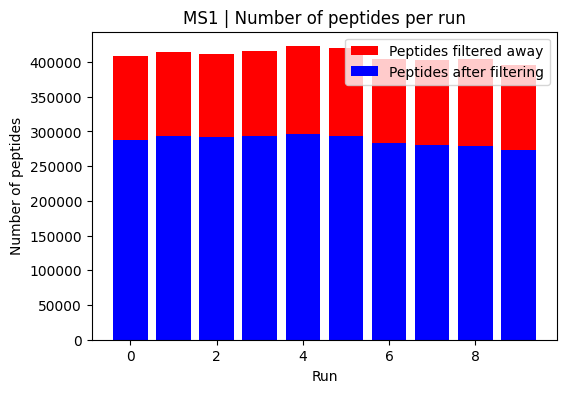

In [8]:
fig, ax = plt.subplots(figsize=(6, 4))

ax.bar(range(len(MS1_raw_peptides_per_run)), MS1_raw_peptides_per_run, color='red')
ax.bar(range(len(MS1_peptides_per_run)), MS1_peptides_per_run, color='blue')
ax.legend(['Peptides filtered away', 'Peptides after filtering'])

ax.set_title("MS1 | Number of peptides per run")
ax.set_xlabel("Run")
ax.set_ylabel("Number of peptides")

In [9]:
print(f"After filtering | MS1 data points: {MS1_data.shape[0]} ({MS1_data.shape[0] / MS1_raw_data.shape[0] * 100:.2f}%)")

After filtering | MS1 data points: 2871496 (70.01%)


### MS2 (MSMS) data preprocessing

Let's look at the features available in the MS2 data:

In [10]:
MS2_raw_data.columns.unique()

Index(['Sequence', 'Length', 'Modifications', 'Modified sequence',
       'Oxidation (M) Probabilities', 'Oxidation (M) Score Diffs',
       'Acetyl (Protein N-term)', 'Oxidation (M)', 'Missed cleavages',
       'Proteins', 'Leading proteins', 'Leading razor protein', 'Gene names',
       'Protein names', 'Type', 'Raw file', 'Experiment', 'MS/MS m/z',
       'Charge', 'm/z', 'Mass', 'Resolution',
       'Uncalibrated - Calibrated m/z [ppm]',
       'Uncalibrated - Calibrated m/z [Da]', 'Mass error [ppm]',
       'Mass error [Da]', 'Uncalibrated mass error [ppm]',
       'Uncalibrated mass error [Da]', 'Max intensity m/z 0', 'Retention time',
       'Retention length', 'Calibrated retention time',
       'Calibrated retention time start', 'Calibrated retention time finish',
       'Retention time calibration', 'Ion mobility index',
       'Ion mobility length', '1/K0', '1/K0 length', 'Calibrated 1/K0', 'CCS',
       'CCS length', 'Match time difference', 'Match m/z difference',
       '

Let's filter out low quality peptides.

In [11]:
# filter out low quality peptides
MS2_data = MS2_raw_data.loc[(MS2_raw_data['Charge'] != 1) & (MS2_raw_data['Intensity'] > 0)]

# keep the most intense peptides
MS2_data = MS2_data.loc[MS2_data.groupby(['Modified sequence', 'Charge', 'Raw file'])['Intensity'].idxmax()]

# remove contaminants
MS2_data = MS2_data.loc[[(not bool(re.search('CON__|REV__', i))) for i in MS2_data['Leading razor protein'].tolist()]]

# define identifier for each peptide
MS2_data['PrecursorID'] = MS2_data['Modified sequence'].astype(str).str.cat(MS2_data['Charge'].astype(str), sep='')

In [12]:
MS2_raw_peptides_per_run = [np.sum(MS2_raw_data['Raw file'] == run) for run in MS2_raw_data['Raw file'].unique()]
MS2_peptides_per_run = [np.sum(MS2_data['Raw file'] == run) for run in MS2_data['Raw file'].unique()]

Text(0, 0.5, 'Number of peptides')

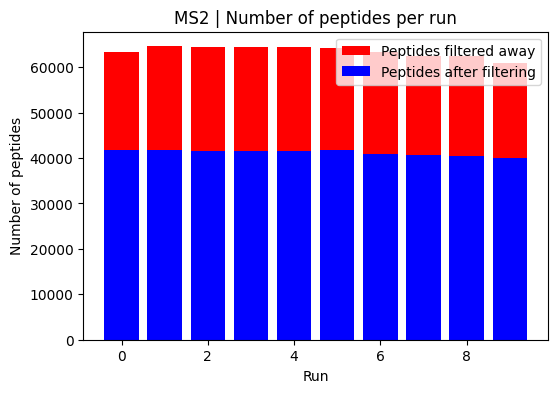

In [13]:
fig, ax = plt.subplots(figsize=(6, 4))

ax.bar(range(len(MS2_raw_peptides_per_run)), MS2_raw_peptides_per_run, color='red')
ax.bar(range(len(MS2_peptides_per_run)), MS2_peptides_per_run, color='blue')
ax.legend(['Peptides filtered away', 'Peptides after filtering'])

ax.set_title("MS2 | Number of peptides per run")
ax.set_xlabel("Run")
ax.set_ylabel("Number of peptides")

In [14]:
print(f"After filtering | MS2 data points: {MS2_data.shape[0]} ({MS2_data.shape[0] / MS2_raw_data.shape[0] * 100:.2f}%)")

After filtering | MS2 data points: 411838 (64.91%)


Let's see how many runs a peptide is present in.

In [15]:
peptides_abundances = MS2_data['PrecursorID'].value_counts()

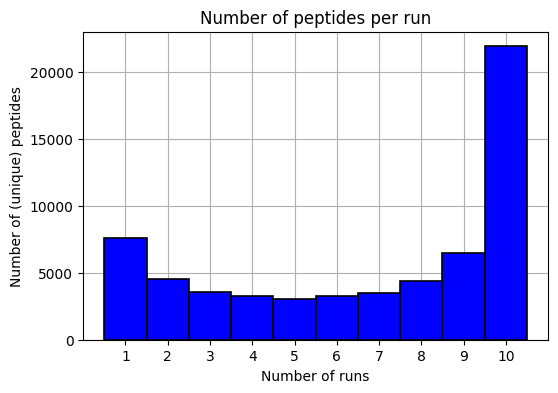

In [16]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.hist(peptides_abundances, bins=range(1, np.max(peptides_abundances)+2), color='blue', edgecolor='black', linewidth=1.2, align='left')
ax.set_xticks(range(1, np.max(peptides_abundances)+1))
ax.set_title('Number of peptides per run')
ax.set_xlabel('Number of runs')
ax.set_ylabel('Number of (unique) peptides')
ax.grid(True)
ax.set_axisbelow(True)

### Feature Extraction

Let's extract the features which the model takes as input.

It seems like the two datasets use a different name for 'Ion mobilility index length' / 'Ion mobility length'. Let's rename one of them to be consistent between the datasets.

In [17]:
MS1_data = MS1_data.copy()
MS1_data.rename(columns={'Ion mobility index length': 'Ion mobility length'}, inplace=True)

In [18]:
features = ['Charge','Mass', 'm/z', 'Retention time','Retention length', 'Ion mobility index', 'Ion mobility length','Number of isotopic peaks']

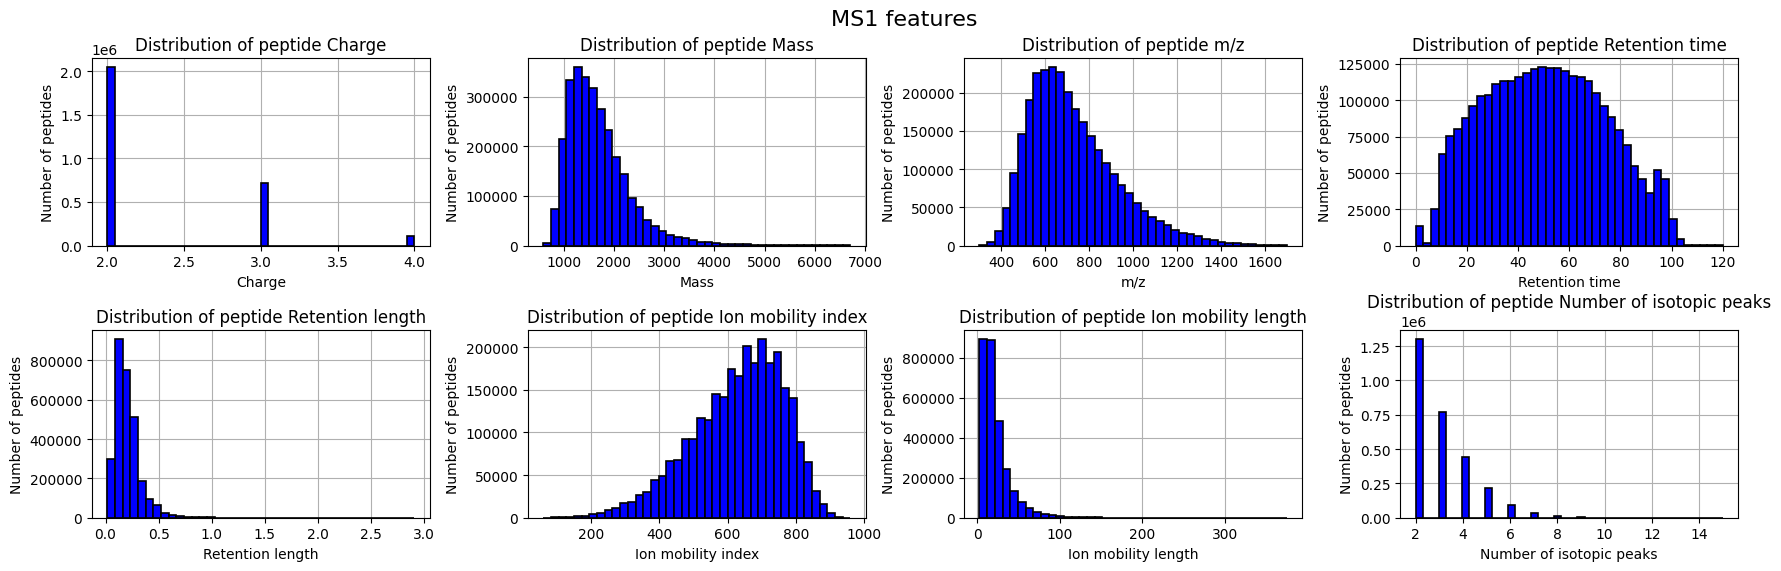

In [19]:
fig, axs = plt.subplots(figsize=(18, 6), ncols=4, nrows=2)
fig.tight_layout(pad=4.0)
fig.suptitle('MS1 features', fontsize=16)

for i, feature in enumerate(features):
    ax = axs[i // 4][i % 4]
    ax.hist(MS1_data[feature], bins=40, color='blue', edgecolor='black', linewidth=1.2)
    ax.set_xlabel(feature)
    ax.set_ylabel('Number of peptides')
    ax.set_title('Distribution of peptide {}'.format(feature))
    ax.grid(True)
    ax.set_axisbelow(True)

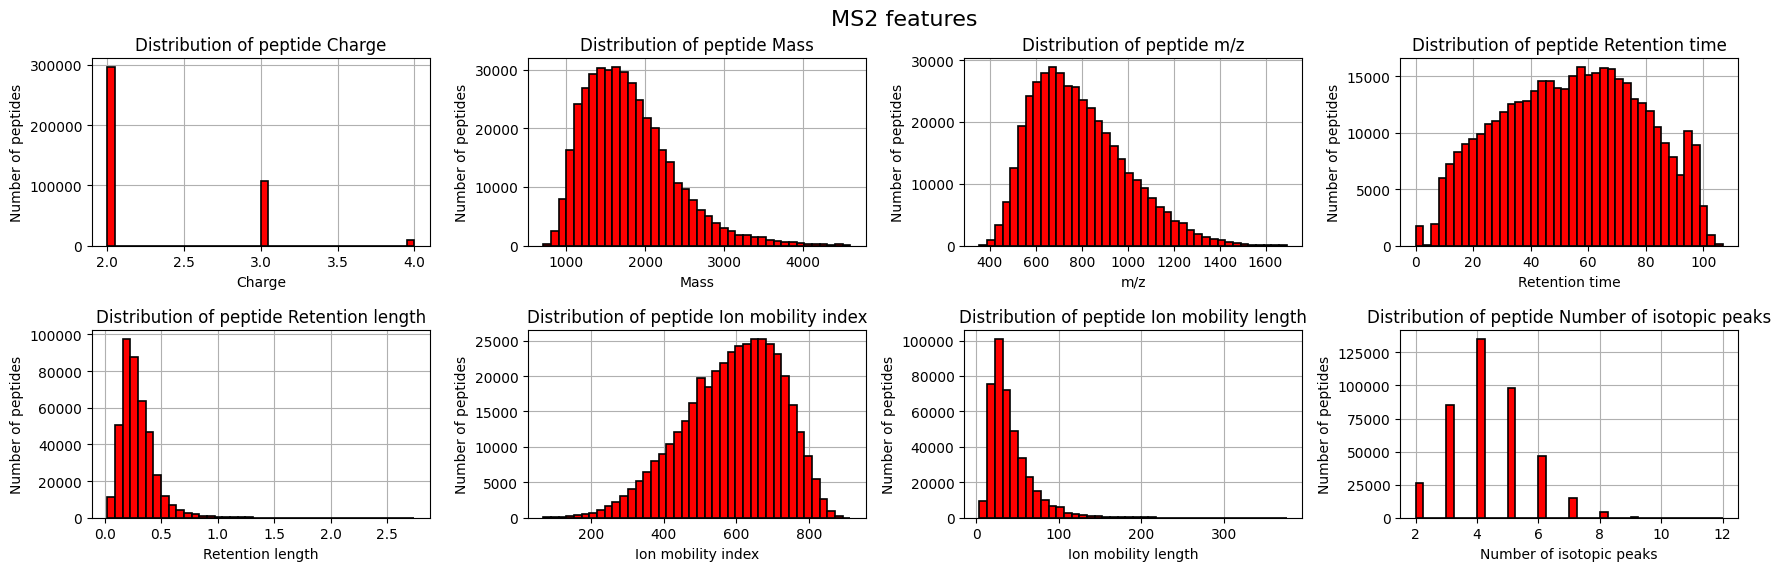

In [20]:
fig, axs = plt.subplots(figsize=(18, 6), ncols=4, nrows=2)
fig.tight_layout(pad=4.0)
fig.suptitle('MS2 features', fontsize=16)

for i, feature in enumerate(features):
    ax = axs[i // 4][i % 4]
    ax.hist(MS2_data[feature], bins=40, color='red', edgecolor='black', linewidth=1.2)
    ax.set_xlabel(feature)
    ax.set_ylabel('Number of peptides')
    ax.set_title('Distribution of peptide {}'.format(feature))
    ax.grid(True)
    ax.set_axisbelow(True)

In [21]:
MS1_features = MS1_data[features]
MS2_features = MS2_data[features]

## PIPP model

### Computing the Embeddings

Let's load the model and compute the embeddings.

In [22]:
model = pipp.Peptideprotonet.load(PRETRAINED_MODEL_PATH)

In [23]:
MS1_embeddings = model.get_latent_representations(MS1_features)

In [24]:
MS2_embeddings = model.get_latent_representations(MS2_features)

Let's look at the embedding space.
We'll look at a subset of peptides due to memory limitations.

In [25]:
N = 50_000
random_indices = np.random.choice(range(len(MS2_embeddings)), size=N, replace=False)

Let's also add some "random" peptides to ensure all possible runs of at least a few peptides are included.

In [26]:
high_coverage_peptides_to_include = [
    '_(ac)AAAAAAAAAAGAAGGR_2',
    '_LGMENDDTAVQYAIGR_2',
    '_LGHVVMGNNAVSPYQQVIEK_2',
    '_LEEVLSTEGAEENGNSDK_2',
    '_PAPQMNGSTGDAR_2',
    '_HLQINQTFEELR_2',
    '_LLAGEDGTSER_2',
    '_LETMPLYLEDDIRPDIK_3',
    '_LFNDSSPVVLEESWDALNAITK_3',
]

low_coverage_peptides_to_include = [
    '_ELFEQYGAVYEINVLR_3',
    '_ELFDELVK_2',
    '_FLGDYVENLNK_2',
    '_HHSQQAPQAEAPCLLR_3',
    '_HFSTTTNNIQSR_2',
    '_LEEIAELVASSLPSPLR_3',
    '_AVLEQFGFPLTGTEAR_2',
    '_VPQFSFLDIFPK_2',
    '_VGPYHNPQETYHYYQLPVCCPEK_3',
    '_FDSASSSYYLDMHSLPHVINPVESR_4',
]

peptides_to_include = high_coverage_peptides_to_include + low_coverage_peptides_to_include

custom_indices = [MS2_data.index[MS2_data['PrecursorID'] == peptide].tolist() for peptide in peptides_to_include]
custom_indices = [peptide for peptide_runs in custom_indices for peptide in peptide_runs]
custom_indices = [MS2_data.index.get_loc(i) for i in custom_indices]

# print(peptides_abundances)

In [27]:
indices = np.unique(np.concatenate((random_indices, custom_indices)))

In [28]:
MS2_data_subset = MS2_data.iloc[indices]
MS2_embeddings_subset = MS2_embeddings[indices]

Let's compute the UMAP for plotting.

In [29]:
reducer = umap.UMAP(metric = 'cosine')
umap_embedding = reducer.fit_transform(MS2_embeddings_subset)

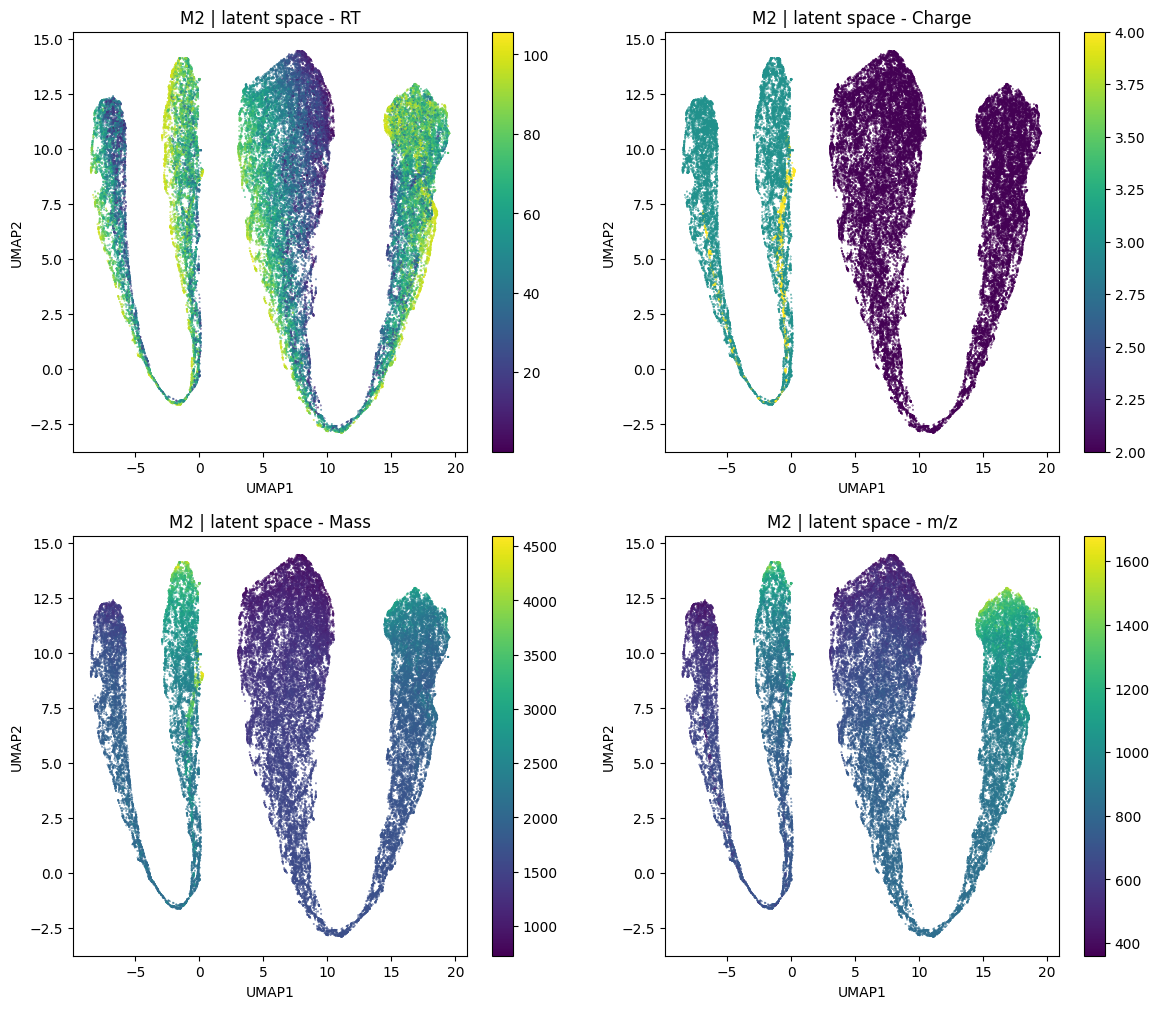

In [30]:
fig, axs = plt.subplots(figsize=(14, 12), ncols=2, nrows=2)

ax = axs[0][0]
sp = ax.scatter(umap_embedding[:,0], umap_embedding[:,1], c=MS2_data_subset['Retention time'], s=0.1)
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.set_title('M2 | latent space - RT')
fig.colorbar(sp)

ax = axs[0][1]
sp = ax.scatter(umap_embedding[:,0], umap_embedding[:,1], c=MS2_data_subset['Charge'], s=0.1)
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.set_title('M2 | latent space - Charge')
fig.colorbar(sp)

ax = axs[1][0]
sp = ax.scatter(umap_embedding[:,0], umap_embedding[:,1], c=MS2_data_subset['Mass'], s=0.1)
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.set_title('M2 | latent space - Mass')
fig.colorbar(sp)

ax = axs[1][1]
sp = ax.scatter(umap_embedding[:,0], umap_embedding[:,1], c=MS2_data_subset['m/z'], s=0.1)
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.set_title('M2 | latent space - m/z')
fig.colorbar(sp)

Let's also plot the latent space of the MS2 data together with some low coverage and high coverage peptides.

Text(0.5, 1.0, 'M2 | latent space - low coverage peptides')

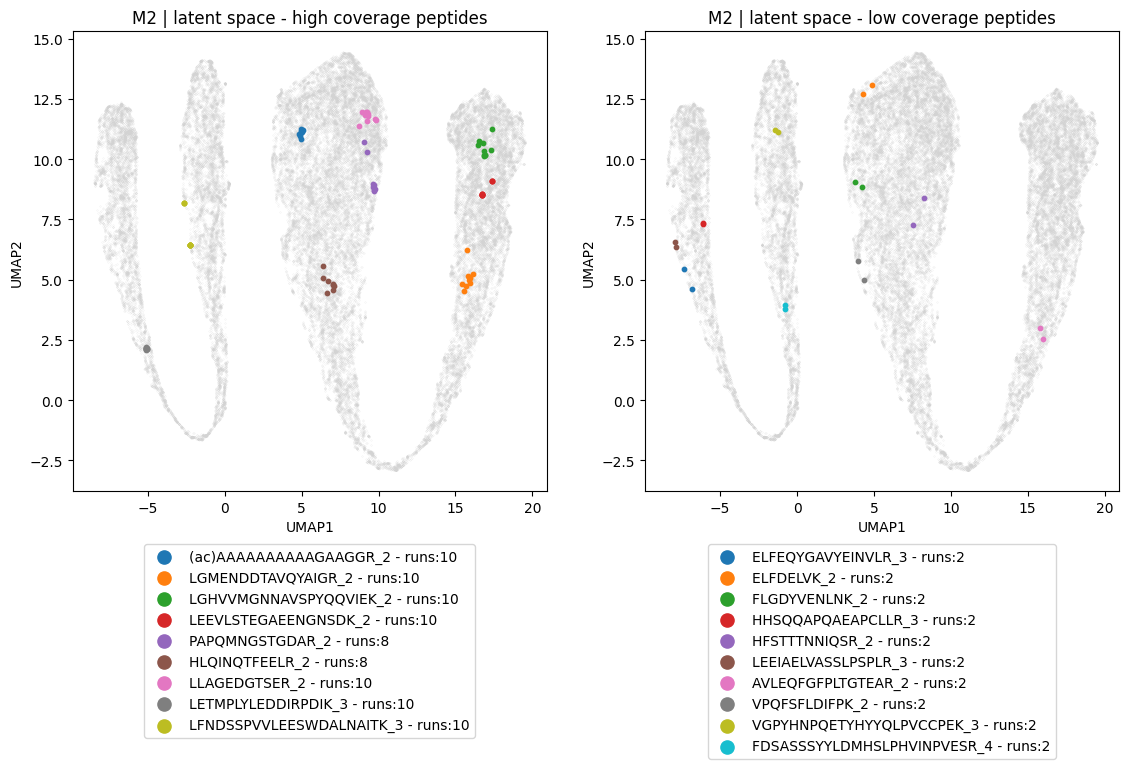

In [31]:
fig, axs = plt.subplots(figsize=(12, 6), ncols=2, nrows=1)
fig.tight_layout(pad=4.0)

# high coverage peptides
ax = axs[0]
ax.scatter(umap_embedding[:,0], umap_embedding[:,1], s=0.01, color='lightgrey')

for i, peptide in enumerate(high_coverage_peptides_to_include):
    peptide_ref_indices = np.where(MS2_data_subset['PrecursorID'] == peptide)
    ax.scatter(umap_embedding[peptide_ref_indices,0], umap_embedding[peptide_ref_indices,1], s=10, color=plt.cm.tab10(i), label=f"{peptide[1:]} - runs:{peptides_abundances[peptide]}")

ax.legend(markerscale=3, loc='upper center', bbox_to_anchor=(0.5, -0.1))
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.set_title('M2 | latent space - high coverage peptides')

# low coverage peptides
ax = axs[1]
ax.scatter(umap_embedding[:,0], umap_embedding[:,1], s=0.01, color='lightgrey')

for i, peptide in enumerate(low_coverage_peptides_to_include):
    peptide_ref_indices = np.where(MS2_data_subset['PrecursorID'] == peptide)
    ax.scatter(umap_embedding[peptide_ref_indices,0], umap_embedding[peptide_ref_indices,1], s=10, color=plt.cm.tab10(i), label=f"{peptide[1:]} - runs:{peptides_abundances[peptide]}")

ax.legend(markerscale=3, loc='upper center', bbox_to_anchor=(0.5, -0.1))
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.set_title('M2 | latent space - low coverage peptides')

## Peptide Identity Propagation

Let's define some support functions which will later be refactored.

In [32]:
def _compute_weights(distances):
    # convert distances to affinities
    stds = np.std(distances, axis=1)
    stds = (2.0 / stds) ** 2
    stds = stds.reshape(-1, 1)
    distances_tilda = np.exp(-np.true_divide(distances, stds))

    # @NOTE: handle division-by-0, by setting the output "weight" to 0 instead of nan.
    #weights = distances_tilda / np.sum(distances_tilda, axis=1, keepdims=True)
    weights = np.divide(distances_tilda, np.sum(distances_tilda, axis=1, keepdims=True), out=np.zeros_like(distances_tilda), where=distances_tilda != 0)
    
    return weights

In [33]:
def _compute_prediction_with_charge_filter(query_charges, neighbours_weights, neighbours_charges):
    """Get highest weight category."""
    N = neighbours_weights.shape[0]
    predictions = np.zeros((N,), dtype=np.int64)
    confidence = np.zeros((N,), dtype=np.float64)

    for i in range(N):
        query_weights = neighbours_weights[i]
        query_charge = query_charges[i]
        nb_charges = neighbours_charges[i]

        ps = query_weights * (query_charge == nb_charges)

        # @NOTE: handle division-by-0, by setting the output "weight" to 0 instead of nan.
        #probs = ps / np.sum(ps)
        probs = np.divide(ps, np.sum(ps), out=np.zeros_like(ps), where=ps != 0)
        
        predictions[i] = np.argmax(probs)
        confidence[i] = np.max(probs)

    return predictions, confidence


### Identification on the MS1 data

#### Computing the Prototypes

Let's compute the prototype for each peptide over all runs.

In [34]:
prototypes_groups = defaultdict(list)

for i in range(MS2_data.shape[0]):
    peptide = MS2_data.iloc[i]
    peptide_id = peptide['PrecursorID']
    embedding = MS2_embeddings[i]
    prototypes_groups[peptide_id].append(embedding)

In [35]:
prototypes = {k: np.mean(v, axis=0) for k, v in prototypes_groups.items()}

In [36]:
print("Number of prototypes: {}".format(len(prototypes)))

Number of prototypes: 61517


For easier access.

In [37]:
prototype_list = [(k, v) for k, v in prototypes.items()]

prototype_precursor_ids = np.array([k for k, _ in prototype_list])
prototype_charges = np.array([int(k[-1]) for k in prototype_precursor_ids])
prototype_embeddings = np.array([v for _, v in prototype_list])

#### Identifying peptides

In [38]:
k = 5

query_embeddings = MS1_embeddings
query_charges = MS1_data['Charge'].values

# Defined earlier:
#   prototype_embeddings
#   prototype_charges

In [39]:
knn_index = NNDescent(prototype_embeddings, metric='euclidean', n_jobs=-1)
neighbours, distances = knn_index.query(query_embeddings, k=k)

In [40]:
neighbours_weights = _compute_weights(distances)
neighbours_charges = np.array([prototype_charges[q_neighbours] for q_neighbours in neighbours])

In [41]:
identities_args, confidence = _compute_prediction_with_charge_filter(query_charges, neighbours_weights, neighbours_charges)

In [42]:
identities_ids = neighbours[np.arange(identities_args.shape[0]), identities_args]
identities = prototype_precursor_ids[identities_ids]


In [43]:
MS1_data['Identification'] = identities
MS1_data['Identification Confidence'] = confidence

Let's plot the distribution of the confidence scores for the MS1 identifications. Additionally, we'll add a threshold to the plot, which we'll use to filter out low confidence identifications.

Text(0.26, 500000.0, 'Peptides identified: 8685 (0.30%)')

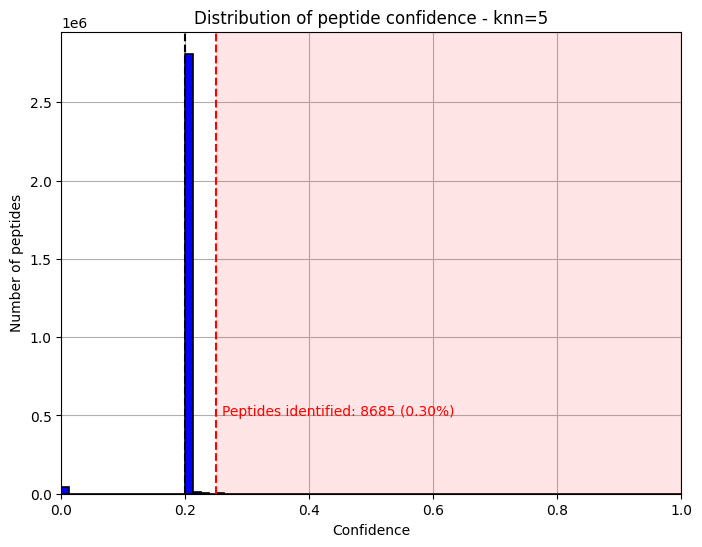

In [44]:
peptide_threshold = 0.25

fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(MS1_data['Identification Confidence'], bins=80, color='blue', edgecolor='black', linewidth=1.2)
ax.set_xlabel('Confidence')
ax.set_ylabel('Number of peptides')
ax.set_title(f'Distribution of peptide confidence - knn={k}')
ax.set_xlim([0, 1])
ax.grid(True)
ax.set_axisbelow(True)

ax.axvline(x=peptide_threshold, color='red', linestyle='--')
ax.axvline(x=1/k, color='black', linestyle='--')
ax.axvspan(peptide_threshold, 1, alpha=0.1, color='red')

identified_count = np.sum(MS1_data['Identification Confidence'] > peptide_threshold)
ax.text(peptide_threshold + 0.01, 5e5, f'Peptides identified: {identified_count} ({identified_count / len(MS1_data) * 100:.2f}%)', color='red')

### Identification on held-out MS2 run

Let's hold out all the peptides in the MS2 dataset for a specific run and see how many of them are identified.

In [45]:
runs = MS1_data['Raw file'].unique()

run_to_benchmark = runs[0]
print('Run to benchmark: {}'.format(run_to_benchmark))

other_runs = runs[runs != run_to_benchmark]

MS2_data_subset = MS2_data[MS2_data['Raw file'] != run_to_benchmark]
MS2_embeddings_subset = MS2_embeddings[MS2_data['Raw file'] != run_to_benchmark]

MS2_data_benchmark = MS2_data[MS2_data['Raw file'] == run_to_benchmark].copy()
MS2_embeddings_benchmark = MS2_embeddings[MS2_data['Raw file'] == run_to_benchmark]

Run to benchmark: 20190122_HeLa_QC_Slot1-47_1_3219


#### Computing the Prototypes

Let's compute the prototypes.

In [46]:
prototypes_groups = defaultdict(list)

for i in range(MS2_data_subset.shape[0]):
    peptide = MS2_data_subset.iloc[i]
    peptide_id = peptide['PrecursorID']
    embedding = MS2_embeddings_subset[i]
    prototypes_groups[peptide_id].append(embedding)

In [47]:
prototypes = {k: np.mean(v, axis=0) for k, v in prototypes_groups.items()}

In [48]:
print("Number of prototypes: {}".format(len(prototypes)))

Number of prototypes: 60544


For easier access.

In [49]:
prototype_list = [(k, v) for k, v in prototypes.items()]

prototype_precursor_ids = np.array([k for k, _ in prototype_list])
prototype_charges = np.array([int(k[-1]) for k in prototype_precursor_ids])
prototype_embeddings = np.array([v for _, v in prototype_list])

#### Identifying peptides

In [50]:
k = 5

query_embeddings = MS2_embeddings_benchmark
query_charges = MS2_data_benchmark['Charge'].values

In [51]:
knn_index = NNDescent(prototype_embeddings, metric='euclidean', n_jobs=-1)
neighbours, distances = knn_index.query(query_embeddings, k=k)

In [52]:
neighbours_weights = _compute_weights(distances)
neighbours_charges = np.array([prototype_charges[q_neighbours] for q_neighbours in neighbours])

In [53]:
identities_args, confidence = _compute_prediction_with_charge_filter(query_charges, neighbours_weights, neighbours_charges)

In [54]:
identities_ids = neighbours[np.arange(identities_args.shape[0]), identities_args]
identities = prototype_precursor_ids[identities_ids]

In [55]:
MS2_data_benchmark['Identification'] = identities
MS2_data_benchmark['Identification Confidence'] = confidence

Let's plot the distribution of the confidence scores for the MS2 identifications. Additionally, we'll add a threshold to the plot, which we'll use to filter out low confidence identifications.

Text(0.21000000000000002, 5000, 'Peptides identified correctly: 28604 (68.56%)')

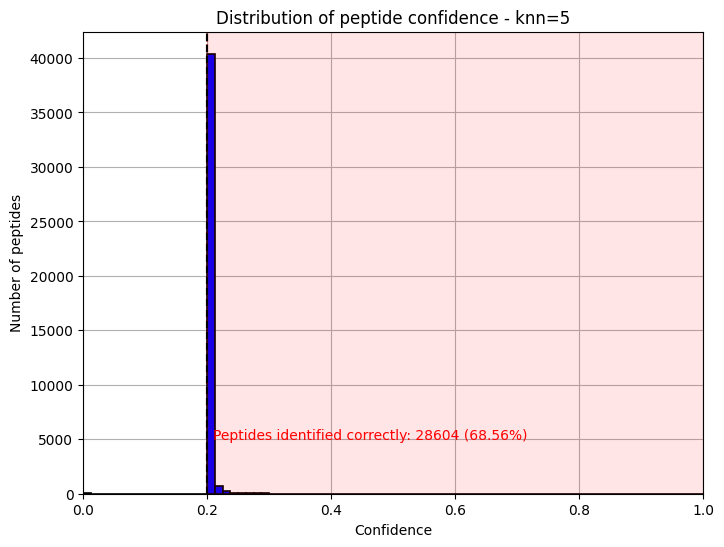

In [56]:
peptide_threshold = 0.2


fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(MS2_data_benchmark['Identification Confidence'], bins=80, color='blue', edgecolor='black', linewidth=1.2)
ax.set_xlabel('Confidence')
ax.set_ylabel('Number of peptides')
ax.set_title(f'Distribution of peptide confidence - knn={k}')
ax.set_xlim([0, 1])
ax.grid(True)
ax.set_axisbelow(True)

ax.axvline(x=peptide_threshold, color='red', linestyle='--')
ax.axvline(x=1/k, color='black', linestyle='--')
ax.axvspan(peptide_threshold, 1, alpha=0.1, color='red')

benchmark_threshold = MS2_data_benchmark[MS2_data_benchmark['Identification Confidence'] > peptide_threshold]
matches = np.sum(benchmark_threshold['PrecursorID'] == benchmark_threshold['Identification'])

identified_count = np.sum(MS2_data_benchmark['Identification Confidence'] > peptide_threshold)
ax.text(peptide_threshold + 0.01, 5000, f'Peptides identified correctly: {matches} ({matches / benchmark_threshold.shape[0] * 100:.2f}%)', color='red')